In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

Main program

'Plant transfer function'

TransferFunction(
array([0.04, 7.3 ]),
array([9.000e-05, 7.600e-04, 1.387e-01, 0.000e+00, 0.000e+00]),
outputs=1, inputs=1)

'Shifted plant transfer function'

TransferFunction(
array([0.04      , 7.30000108]),
array([9.00000000e-05, 7.60009727e-04, 1.38700062e-01, 7.49493694e-06,
       1.01251015e-10]),
outputs=1, inputs=1)

'Reference transfer function'

TransferFunction(
array([1]),
array([0.07304602, 0.32432432, 1.        ]),
outputs=1, inputs=1)

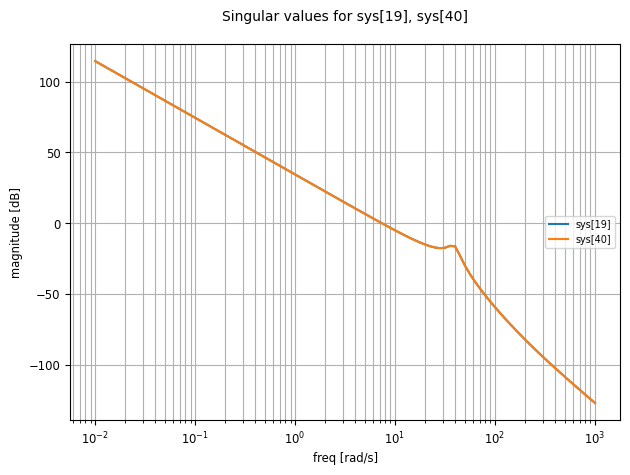

In [2]:
# Plant P and uncertainty
Jmax = 0.010
Jmin = 0.008
J0 = 0.5*(Jmax+Jmin)
B = 0.04
KK= 7.3
H = 0.01

# Neglected pole
taumax = 0.0012

s = ct.tf('s')
I = ct.ss([],[],[],1)

# Frequency range for mu computations
omega = np.logspace(-2, 3, 101)

# Real nominal plant
P = (B*s+KK)/((H*J0)*s*s*s*s + B*(H+J0)*s*s*s + KK*(H+J0)*s*s)

# Shift the poles at zero to the left by 1e-4*wnp where wnp is the natural frequency of the complex poles
# to avoid numerical problems in hinfsyn
wnp = np.sqrt(KK/H)
ep = 1e-6*wnp
sep = s+ep
Ps = (B*sep+KK)/((H*J0)*sep*sep*sep*sep + B*(H+J0)*sep*sep*sep + KK*(H+J0)*sep*sep)

ct.freqplot.singular_values_plot(P, omega, dB=True);
ct.freqplot.singular_values_plot(Ps, omega, dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')

display("Plant transfer function", P)
display("Shifted plant transfer function", Ps)

# Closed loop to be matched
ts = 1
smax = 0.2
wn = 3.7
zeta = 0.6
denM = [1/wn/wn, 2*zeta/wn, 1]
M = ct.tf([1], denM)
display("Reference transfer function", M)

Define performance weight and uncertainty weight 

In [3]:
# Model matching weight Wm 
Mm = 10
em = 0.001
wb = 10*wn # Crossover frequency
Wm = ct.ss(rb.weightS(wb, Mm, em, 1))

# Weight on noise
Mu = 1000
eu = 0.001
wbc = 30*wn # Crossover frequency
Wu = ct.ss(rb.weightU(wbc, Mu, eu, 5))

Nominal performance design

0 states have been removed from the model


0.07081043906509876

Text(0.5, 1.0, 'Singular values of T for the nominal system')

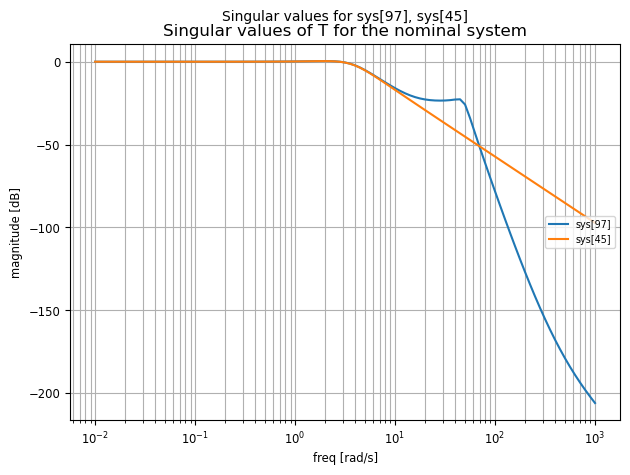

In [4]:
P.input_labels = ['u']
P.output_labels = ['yp']
Ps.input_labels = ['u']
Ps.output_labels = ['yp']
M.input_labels = ['w']
M.output_labels = ['x']
Wu.input_labels = ['u']
Wu.output_labels = ['z2']
Wm.input_labels = ['q']
Wm.output_labels = ['z1']

# Feedback: y = r-ybar
fbk = ct.summing_junction(['w','-yp'], 'y')

# Model matching summing junction
Msj = ct.summing_junction(['yp','-x'], 'q')

# Controller I/O sizes
f = 1

# Initial gamma
initgamma = 1e1

G = ct.minreal(ct.interconnect([Ps, M, Wm, Wu, fbk, Msj],
                    inputs=['w','u'],
                    outputs=['z1','z2','y']))


Knom, _, gamma, rcond = rb.hinfsyn(G, f, f, initgamma)

display(gamma)

Knom.input_labels = ['y']
Knom.output_labels = ['u'] 
Tnom = ct.minreal(ct.interconnect([P, M, Knom, Wm, Wu, fbk, Msj],
                    inputs=['w'],
                    outputs=['yp'], check_unused=False), verbose=False)

ct.freqplot.singular_values_plot(Tnom, omega, dB=True);
ct.freqplot.singular_values_plot(M, omega, dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T for the nominal system')

Text(0.5, 1.0, 'Singular values of T-M for the nominal system')

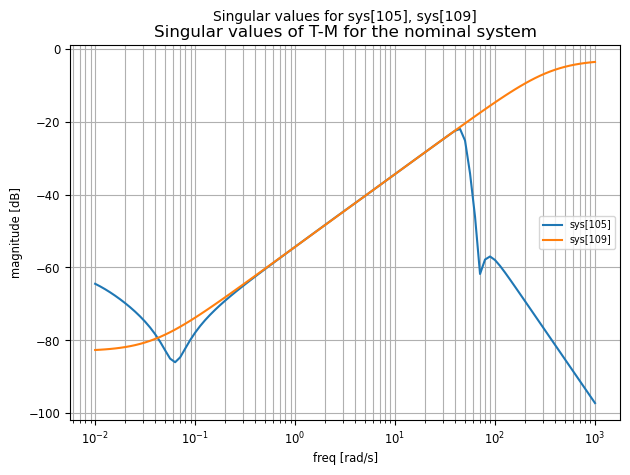

In [5]:
ct.freqplot.singular_values_plot(Tnom-M, omega, dB=True);
ct.freqplot.singular_values_plot(rb.invss(Wm)*gamma, omega, dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T-M for the nominal system')

Text(0.5, 1.0, 'Singular values of KS for the nominal system')

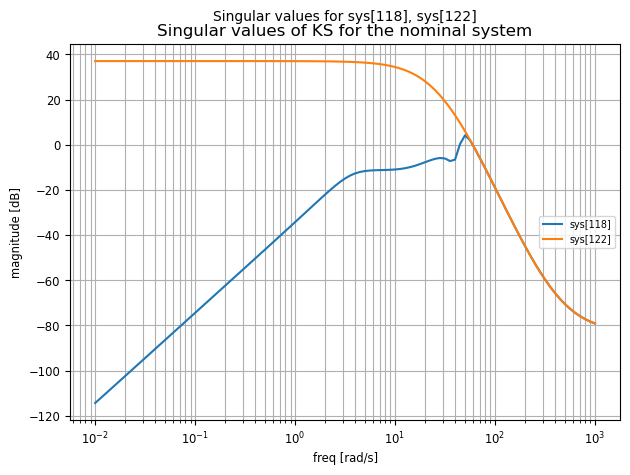

In [6]:
KSnom = ct.minreal(ct.interconnect([P, M, Knom, Wm, Wu, fbk, Msj],
                    inputs=['w'],
                    outputs=['u'], check_unused=False), verbose=False)
ct.freqplot.singular_values_plot(KSnom, omega, dB=True);
ct.freqplot.singular_values_plot(rb.invss(Wu)*gamma, omega, dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of KS for the nominal system')

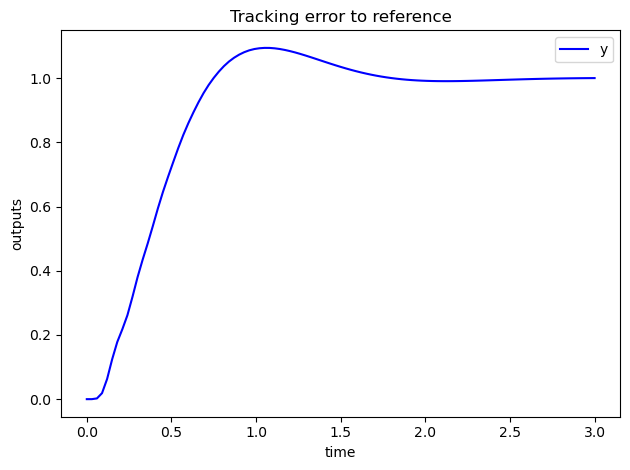

In [7]:
# Compute reponse to step of [1,-1] of a system with 2 inputs and 2 outputs
t = np.linspace(0, 3, 101)
tt, y = ct.step_response(Tnom, t)
 
    
plt.plot(tt, y, 'b', label= 'y' )
plt.xlabel('time')
plt.ylabel('outputs')
plt.legend()
plt.title('Tracking error to reference')
plt.tight_layout()

Robust stability of nominal design

In [8]:
# Uncertainty block weight for uncertain J Wi
Wi1 = (Jmax/J0-1) * ct.tf([H,B,KK],[H,B*(1+H/J0),KK*(1+H/J0)])

# Neglected pole uncertainty weight
Wi2 = (taumax*s)/(1+taumax*s)

'Peak upper bound (nubar):'

0.2849840350621414

Text(0.5, 1.0, '$\\bar\\mu$')

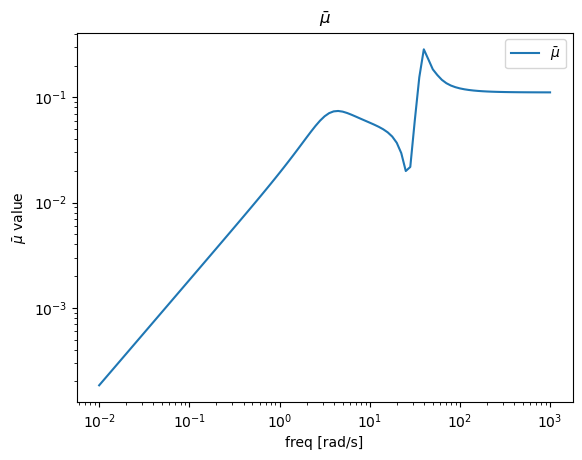

In [9]:
Wi1.input_labels = ['up']
Wi1.output_labels = ['zd1']
Wi2.input_labels = ['yp']
Wi2.output_labels = ['zd2']
P.input_labels = ['up']
P.output_labels = ['yp']


# Summing junction to ybar (additive uncertainty)
D1sj = ct.summing_junction(inputs=['u','-wd1'], output='up')

# Neglected pole summing junction
D2sj = ct.summing_junction(inputs=['wd2','yp'], output='ybar')

# Feedback: y = r-ybar
fbk1 = ct.summing_junction(['-ybar'], 'y')

MM = ct.minreal(ct.interconnect([P, Knom, Wi1, Wi2, fbk1, D1sj, D2sj],
                    inputs=['wd1','wd2'],
                    outputs=['zd1','zd2']), 
                    verbose=False)


# Uncertainty structure
nblock = np.array([1,1])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2])

# Compute mu upper bound and its maximum over frequency
mubound, nubar = rb.mucomp(MM, nblock, itype, omega)
display("Peak upper bound (nubar):",nubar)

plt.loglog(omega, mubound, label=r'$\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'$\bar\mu$')

Robust performance

In [10]:
# Model matching weight Wm 
Mm = 1000
em = 0.15
wb = 70*wn # Crossover frequency
Wm = ct.ss([],[],[],1)*ct.ss(rb.weightS(wb, Mm, em, 1))

# Weight on noise
Mu = 10000
eu = 0.001
wbc = 20*wn # Crossover frequency
Wu = ct.ss([],[],[],1.2)*ct.ss(rb.weightU(wbc, Mu, eu, 4))

# Zero weight for dummy performance input
Ww = ct.ss([],[],[],0)

Ps.input_labels = ['up']
Ps.output_labels = ['yp']
M.input_labels = ['w']
M.output_labels = ['x']
Wu.input_labels = ['u']
Wu.output_labels = ['z2']
Ww.input_labels = ['wdummy']
Ww.output_labels = ['ww']
Wm.input_labels = ['q']
Wm.output_labels = ['z1']
Wi1.input_labels = ['up']
Wi1.output_labels = ['zd1']
Wi2.input_labels = ['yp']
Wi2.output_labels = ['zd2']

# Feedback: y = r-ybar
fbk = ct.summing_junction(['w','ww','-ybar'], 'y')

# Summing junction to ybar (additive uncertainty)
D1sj = ct.summing_junction(['u','-wd1'], 'up')

# Neglected pole summing junction
D2sj = ct.summing_junction(['wd2','yp'], 'ybar')

# Model matching summing junction
Msj = ct.summing_junction(['ybar','-x'], 'q')


# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([Ps, M, Wi1, Wi2, Wm, Wu, Ww, fbk, D1sj, D2sj, Msj],
                    inputs=['wd1','wd2','w','wdummy','u'],
                    outputs=['zd1','zd2','z1','z2','y']), 
                    verbose=False)

# Extended uncertainty structure
nblock = np.array([1,1,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2])

# Do mu-synthesis via D-K iteration
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega, initgamma=2e1,  reduce=0, maxiter=20)


display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  12.267662475454728
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  9.51482354182833
Iteration # 2
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 3
Best upper bound to mu norm of Tzw_delta:  2.636584419613633
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  3
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  4
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  3
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  4
Iteration # 11
N

'Best upper bound (nubar) to mu norm of Tzw_delta: '

2.636584419613633

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

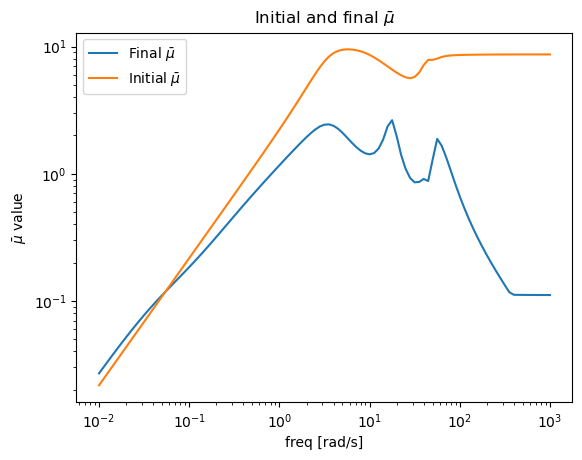

In [11]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Initial and final $\bar\mu$')

/Users/giannibi/anaconda3/envs/rpc2025/lib/python3.10/site-packages/control/nlsys.py:1323: UserWarning: Unused input(s) in InterconnectedSystem: (7, 0)=sys[182].wdummy
  warn(msg)
/Users/giannibi/anaconda3/envs/rpc2025/lib/python3.10/site-packages/control/nlsys.py:1329: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[159].z1; (6, 0) : sys[181].z2
  warn(msg)


Text(0.5, 1.0, 'Singular values of T for the nominal system')

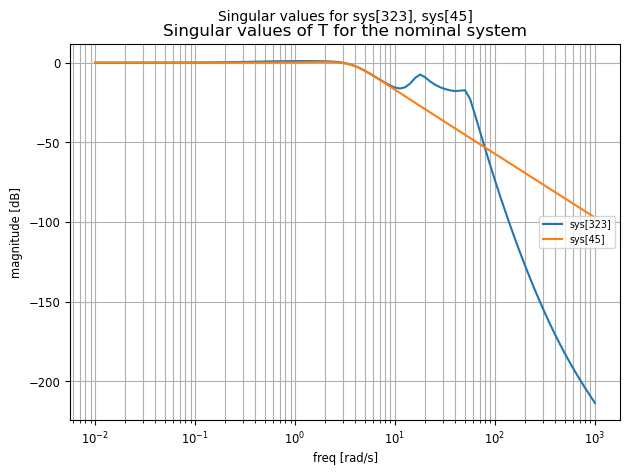

In [12]:
# Compute sensitivity for the nominal system
Delta1 = 0 * I
Delta2 = 0 * I
Delta1.input_labels = ['zd1']
Delta1.output_labels = ['wd1']  
Delta2.input_labels = ['zd2']
Delta2.output_labels = ['wd2']  
K.input_labels = ['y']
K.output_labels = ['u'] 
P.input_labels = ['up']
P.output_labels = ['yp']


T = ct.minreal(ct.interconnect([P, K, M, Wi1, Wi2, Wm, Wu, Ww, fbk, D1sj, D2sj, Msj, Delta1, Delta2],
                    inputs=['w'],
                    outputs=['ybar']), 
                    verbose=False)

ct.freqplot.singular_values_plot(T, omega, dB=True);
ct.freqplot.singular_values_plot(M, omega, dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T for the nominal system')

Text(0.5, 1.0, 'Singular values of T-M for the nominal system')

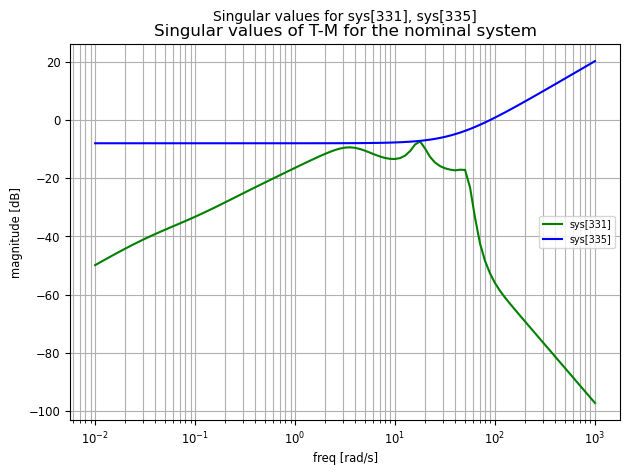

In [13]:
ct.freqplot.singular_values_plot((T-M), omega, color='g', dB=True)
ct.freqplot.singular_values_plot(rb.invss(Wm)*best_nubar, omega, color='b', dB=True)
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T-M for the nominal system')

/Users/giannibi/anaconda3/envs/rpc2025/lib/python3.10/site-packages/control/nlsys.py:1323: UserWarning: Unused input(s) in InterconnectedSystem: (7, 0)=sys[182].wdummy
  warn(msg)
/Users/giannibi/anaconda3/envs/rpc2025/lib/python3.10/site-packages/control/nlsys.py:1329: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[159].z1; (6, 0) : sys[181].z2
  warn(msg)


Text(0.5, 1.0, 'Singular values of KS for the nominal system')

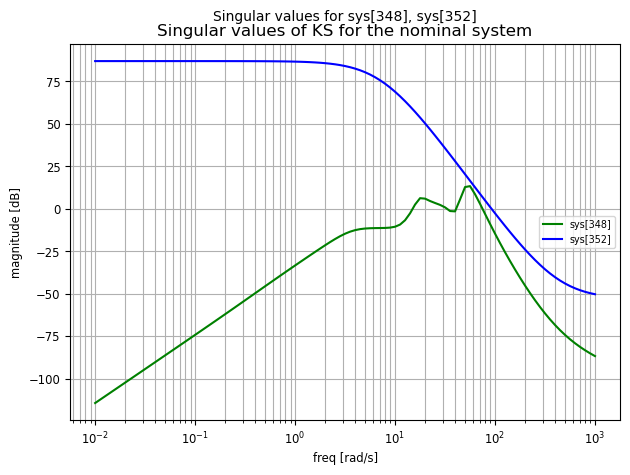

In [14]:
KS = ct.minreal(ct.interconnect([P, K, M, Wi1, Wi2, Wm, Wu, Ww, fbk, D1sj, D2sj, Msj, Delta1, Delta2],
                    inputs=['w'],
                    outputs=['u']), 
                    verbose=False)
ct.freqplot.singular_values_plot(KS, omega, color='g', dB=True);
ct.freqplot.singular_values_plot(rb.invss(Wu)*best_nubar, omega,  color='b', dB=True);
plt.ylabel('magnitude [dB]')
plt.xlabel('freq [rad/s]')
plt.title('Singular values of KS for the nominal system')

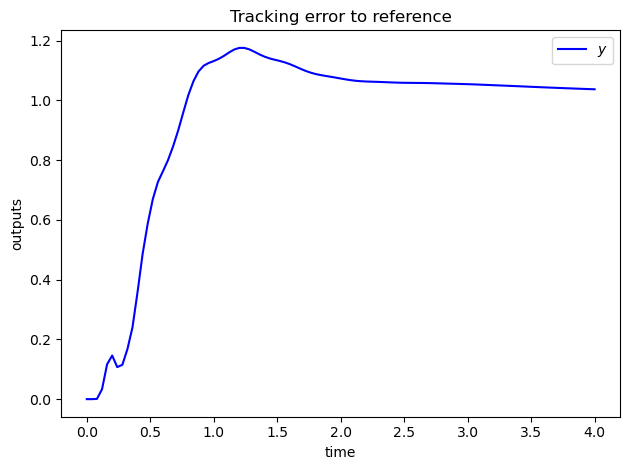

In [15]:
# Compute reponse to step of [1,-1] of a system with 2 inputs and 2 outputs
t = np.linspace(0, 4, 101)
tt, y = ct.step_response(T, t)
 
    
plt.plot(tt, y, 'b', label= '$y$' )
plt.xlabel('time')
plt.ylabel('outputs')
plt.legend()
plt.title('Tracking error to reference')
plt.tight_layout()

/Users/giannibi/anaconda3/envs/rpc2025/lib/python3.10/site-packages/control/lti.py:646: FutureWarning: freqresp() is deprecated; use frequency_response()
  warn("freqresp() is deprecated; use frequency_response()", FutureWarning)


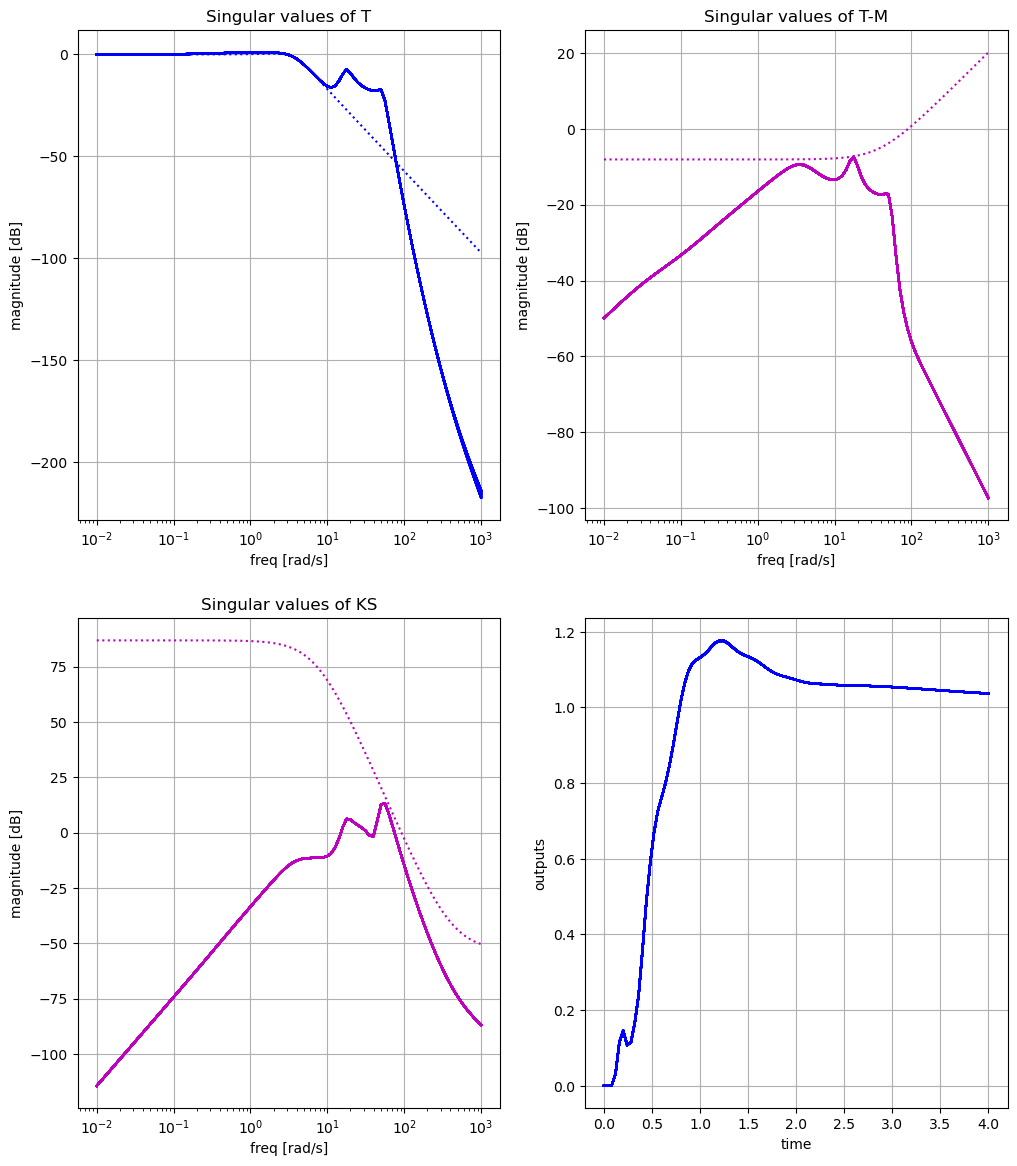

In [16]:
    plt.figure(figsize=(12, 14))
    # Generate some random systems in the uncertainty set
    for i in range(100):
        J = np.round(np.random.uniform(Jmin,Jmax),5)
        tau = np.round(np.random.uniform(0,taumax),5)
        
        P = ct.ss((B*s+KK)/((H*J0)*s*s*s*s + B*(H+J0)*s*s*s + KK*(H+J0)*s*s)/(1+tau*s))
    
        # Compute sensitivities of closed loop system
        S = ct.minreal(ct.feedback(I,P*K),verbose=False)
        T = ct.minreal(ct.feedback(P*K,I),verbose=False)
        KS = K*S

        mag, phase, omegax = ct.freqresp(T, omega)
        plt.subplot(2, 2, 1)
        plt.semilogx(omegax, 20*np.log10(mag), 'b')
        #plt.ylim([-60, 10])
        #plt.xlim([1e-2, 1e3])
        
        mag, phase, omegax = ct.freqresp(T-M, omega)
        plt.subplot(2,2, 2)
        plt.semilogx(omegax, 20*np.log10(mag), 'm')
        #plt.ylim([-60, 10])
        #plt.xlim([1e-2, 1e3])

        mag, phase, omegax = ct.freqresp(KS, omega)
        plt.subplot(2,2, 3)
        plt.semilogx(omegax, 20*np.log10(mag), 'm')
        #plt.ylim([-60, 10])
        #plt.xlim([1e-2, 1e3])
    
        plt.subplot(2,2, 4)
        tt, y = ct.step_response(T, t)
        plt.plot(tt, y, 'b', label= '$y$' )
    
    plt.subplot(2,2, 1)
    mag, phase, omegax = ct.freqresp(M, omega)
    plt.semilogx(omegax, 20*np.log10(mag), 'b:')
    plt.title('Singular values of T')
    #plt.ylim([-60, 10])
    plt.ylabel('magnitude [dB]')
    #plt.xlim([1e-2, 1e3])
    plt.xlabel('freq [rad/s]')
    plt.grid(visible=True)

    plt.subplot(2,2, 2)
    mag, phase, omegax = ct.freqresp(rb.invss(Wm)*best_nubar, omega)
    plt.semilogx(omegax, 20*np.log10(mag), 'm:')
    plt.title('Singular values of T-M')
    #plt.ylim([-60, 10])
    plt.ylabel('magnitude [dB]')
    #plt.xlim([1e-2, 1e3])
    plt.xlabel('freq [rad/s]')
    plt.grid(visible=True)
    
    plt.subplot(2,2, 3)
    mag, phase, omegax = ct.freqresp(rb.invss(Wu)*best_nubar, omega)
    plt.semilogx(omegax, 20*np.log10(mag), 'm:')
    plt.title('Singular values of KS')
    #plt.ylim([-60, 10])
    plt.ylabel('magnitude [dB]')
    #plt.xlim([1e-2, 1e3])
    plt.xlabel('freq [rad/s]')
    plt.grid(visible=True)
    
    plt.subplot(2,2, 4)
    plt.plot(tt, y, 'b', label= '$y$' )
    plt.xlabel('time')
    plt.ylabel('outputs')  
    plt.grid(visible=True)

    #plt.tight_layout()
    plt.show()
    